In [1]:
import os, sys
import itertools

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as at
from astropy.io import fits
import astropy.units as u
from astropy import table
from astropy.table import join,vstack,Table
from astropy.coordinates import SkyCoord

from analyze_cluster_output import colors, shapes
from analyze_cluster_output import mass_to_bp_rp, id_solar
from analyze_cluster_output import read_cluster_visual
from plot_periods import plot_periodcolor_histogram

In [2]:
clusters = ["IC_2391","Collinder_135","NGC_2451A","NGC_2547","IC_2602"]
dates = ["2021-06-22","2021-06-18","2021-06-21","2021-06-21","2021-07-02"]

In [3]:
# My crossmatched catalog
per = at.read("tab_all_stars.csv")
per.dtype

dtype([('TIC', '<i8'), ('GAIAEDR3_ID', '<i8'), ('GAIAEDR3_RA', '<f8'), ('GAIAEDR3_DEC', '<f8'), ('GAIAEDR3_RUWE', '<f8'), ('GAIAEDR3_G', '<f8'), ('GAIAEDR3_G_ERR', '<f8'), ('GAIAEDR3_G_CORRECTED', '<f8'), ('GAIAEDR3_BP', '<f8'), ('GAIAEDR3_BP_ERR', '<f8'), ('GAIAEDR3_RP', '<f8'), ('GAIAEDR3_RP_ERR', '<f8'), ('TMASS_ID', '<f8'), ('TMASS_J', '<f8'), ('TMASS_J_ERR', '<f8'), ('TMASS_H', '<f8'), ('TMASS_H_ERR', '<f8'), ('TMASS_K', '<f8'), ('TMASS_K_ERR', '<f8'), ('HDBscan_MemProb', '<f8'), ('HDBscan_Cluster', '<f8'), ('HDBscan_Stability', '<f8'), ('MemBool', '<f8'), ('angDist_GES', '<f8'), ('GES_Target', '<U16'), ('GES_Cluster', '<U8'), ('GES_MemProb', '<f8'), ('angDist_Cantat-Gaudin', '<f8'), ('CG_MemProb', '<f8'), ('CG_Cluster', '<U13'), ('Prot1', '<f8'), ('Pw1', '<f8'), ('Q1', '<f8'), ('Sig', '<f8'), ('Prot2', '<f8'), ('Pw2', '<f8'), ('Q2', '<f8'), ('MP?', '<U1'), ('SE?', '<U1'), ('LitPeriod', '<f8'), ('LitSource', '<U10'), ('Cluster', '<U13')])

In [4]:
# Phill's new MINESweeper catalog
catfile = "catalogs/catalog_NGC_2547_v0.fits"
with fits.open(catfile) as hdu:
#     print(hdu.info())
    cat = Table(hdu[1].data)
cat.rename_column("GaiaEDR3_ID","GAIAEDR3_ID")
cat.dtype

dtype([('GAIAEDR3_ID', '>i8'), ('av', '>f8'), ('av_lerr', '>f8'), ('av_uerr', '>f8'), ('av_err', '>f8'), ('dist', '>f8'), ('dist_lerr', '>f8'), ('dist_uerr', '>f8'), ('dist_err', '>f8'), ('eep', '>f8'), ('eep_lerr', '>f8'), ('eep_uerr', '>f8'), ('eep_err', '>f8'), ('initial_Mass', '>f8'), ('initial_Mass_lerr', '>f8'), ('initial_Mass_uerr', '>f8'), ('initial_Mass_err', '>f8'), ('initial_[Fe/H]', '>f8'), ('initial_[Fe/H]_lerr', '>f8'), ('initial_[Fe/H]_uerr', '>f8'), ('initial_[Fe/H]_err', '>f8'), ('initial_[a/Fe]', '>f8'), ('initial_[a/Fe]_lerr', '>f8'), ('initial_[a/Fe]_uerr', '>f8'), ('initial_[a/Fe]_err', '>f8'), ('EEP', '>f8'), ('EEP_lerr', '>f8'), ('EEP_uerr', '>f8'), ('EEP_err', '>f8'), ('log(Age)', '>f8'), ('log(Age)_lerr', '>f8'), ('log(Age)_uerr', '>f8'), ('log(Age)_err', '>f8'), ('Mass', '>f8'), ('Mass_lerr', '>f8'), ('Mass_uerr', '>f8'), ('Mass_err', '>f8'), ('log(R)', '>f8'), ('log(R)_lerr', '>f8'), ('log(R)_uerr', '>f8'), ('log(R)_err', '>f8'), ('log(L)', '>f8'), ('log(L)_l

In [5]:
catmatch = join(cat,per,keys=["GAIAEDR3_ID"],join_type="right")

In [6]:
# mod_file = os.path.expanduser("~/Dropbox/Models/UpSco_Mattea2022/UpSco_Mattea2022_00653Myr.txt")
# mod_file = os.path.expanduser("~/Dropbox/Models/UpSco_Mattea2015/UpSco_Mattea2015_00653Myr.txt")
mod_file = os.path.expanduser("~/Dropbox/Models/UpSco_Mattea2022/UpSco_Mattea2022_00030Myr.txt")
mod = at.read(mod_file,names=["mass","prot"])
mod.dtype

dtype([('mass', '<f8'), ('prot', '<f8')])

In [64]:
catmatch.show_in_notebook()

idx,GAIAEDR3_ID,av,av_lerr,av_uerr,av_err,dist,dist_lerr,dist_uerr,dist_err,eep,eep_lerr,eep_uerr,eep_err,initial_Mass,initial_Mass_lerr,initial_Mass_uerr,initial_Mass_err,initial_[Fe/H],initial_[Fe/H]_lerr,initial_[Fe/H]_uerr,initial_[Fe/H]_err,initial_[a/Fe],initial_[a/Fe]_lerr,initial_[a/Fe]_uerr,initial_[a/Fe]_err,EEP,EEP_lerr,EEP_uerr,EEP_err,log(Age),log(Age)_lerr,log(Age)_uerr,log(Age)_err,Mass,Mass_lerr,Mass_uerr,Mass_err,log(R),log(R)_lerr,log(R)_uerr,log(R)_err,log(L),log(L)_lerr,log(L)_uerr,log(L)_err,log(Teff),log(Teff)_lerr,log(Teff)_uerr,log(Teff)_err,[Fe/H],[Fe/H]_lerr,[Fe/H]_uerr,[Fe/H]_err,[a/Fe],[a/Fe]_lerr,[a/Fe]_uerr,[a/Fe]_err,log(g),log(g)_lerr,log(g)_uerr,log(g)_err,TIC,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RUWE,GAIAEDR3_G,GAIAEDR3_G_ERR,GAIAEDR3_G_CORRECTED,GAIAEDR3_BP,GAIAEDR3_BP_ERR,GAIAEDR3_RP,GAIAEDR3_RP_ERR,TMASS_ID,TMASS_J,TMASS_J_ERR,TMASS_H,TMASS_H_ERR,TMASS_K,TMASS_K_ERR,HDBscan_MemProb,HDBscan_Cluster,HDBscan_Stability,MemBool,angDist_GES,GES_Target,GES_Cluster,GES_MemProb,angDist_Cantat-Gaudin,CG_MemProb,CG_Cluster,Prot1,Pw1,Q1,Sig,Prot2,Pw2,Q2,MP?,SE?,LitPeriod,LitSource,Cluster
0,5316965243808427392,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,45975697,131.677,-55.137,1.638,15.069,0.001,15.069,16.736,0.003,13.817,0.001,1.8179237292719296e+18,12.017,0.024,11.481,0.026,11.145,0.021,0.5365475983891542,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,0.005102,1.0,IC_2391,0.4,0.312,1.0,0.028,-9999.0,-9999.0,4.0,m,m,--,--,IC_2391
1,5317059771754582784,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,45781130,131.128,-54.482,8.838,13.782,0.001,13.782,14.978,0.004,12.692,0.002,1.8719493326143834e+18,11.223,0.024,10.557,0.026,10.336,0.023,0.5092620911086917,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,1e+20,1e+20,N/A,2.08,0.627,0.0,0.029,-9999.0,-9999.0,4.0,n,m,--,--,IC_2391
2,5317095677681933184,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,122183696,133.038,-55.24,1.652,16.037,0.003,16.037,17.577,0.009,14.588,0.006,999999.0,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1e+20,1e+20,1e+20,1e+20,1e+20,N/A,N/A,1e+20,0.008052,0.9,IC_2391,-9999.0,-9999.0,2.0,0.029,-9999.0,-9999.0,4.0,n,n,--,--,IC_2391
3,5317101862436296192,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,122417427,133.687,-55.213,2.207,14.57,0.003,14.57,16.088,0.006,13.353,0.005,999999.0,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1.0000000200408773e+20,1e+20,1e+20,1e+20,1e+20,1e+20,N/A,N/A,1e+20,0.002781,1.0,IC_2391,0.37,0.272,0.0,0.027,-9999.0,-9999.0,4.0,n,n,--,--,IC_2391
4,5317364680071917184,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,46116361,131.982,-54.756,1.06,15.788,0.001,15.788,17.397,0.006,14.562,0.003,1.8359029434093427e+18,12.825,0.022,12.239,0.026,11.98,0.023,0.4265613339778499,0.0,0.24671625890317983,1.0,1e+20,N/A,N/A,1e+20,0.003785,0.7,IC_2391,0.76,0.284,0.0,0.028,-9999.0,-9999.0,4.0,n,n,--,--,IC_2391
5,5317423293481147264,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,46223556,131.893,-54.483,0.825,11.921,0.002,11.921,12.432,0.006,11.246,0.004,1.8538997497328138e+18,10.319,0.0

# First we just have to set up the grid and make the model into a histogram

In [68]:
class SpinModel:
    
    def __init__(self,model_year,model_age,period_scale):
        mod_file = os.path.expanduser(f"~/Dropbox/Models/UpSco_Mattea{model_year}/UpSco_Mattea{model_year}_{model_age:05d}Myr.txt")
    #     print(mod_file)
        mod = at.read(mod_file,names=["mass","prot"])
        
        self.mass_bins = np.arange(0.025,1.4,0.1)

        self.period_scale = period_scale
        if period_scale=="log":
            self.period_bins = np.logspace(np.log10(0.08),np.log10(40),200)
        else:
            self.period_bins = np.linspace(0,40,200)

        # Calculate the histogram
        img_raw, self.xedges, self.yedges = np.histogram2d(mod["mass"],mod["prot"],
                                                           bins=[self.mass_bins,self.period_bins])
        # Transpose the image so we can actually plot it
        # by default this is not normalized
        self.img = img_raw.T
        
        self.mass_array = mod["mass"]
        self.prot_array = mod["prot"]

    def normalize(self):
        # Normalize the histogram if desired
        dmass = np.diff(self.mass_bins)
        dper = np.diff(self.period_bins)
        img_nomask_dm = self.img * dmass
        img_nomask_dmdp = img_nomask_dm * dper[:,np.newaxis]

        img_sum = np.sum(img_nomask_dmdp)
        img_nomask_final = img_nomask_dmdp / img_sum
        self.img = img_nomask_final
    
    def add_mask(self):
        img_nomask = np.copy(self.img)
        
        # mask the image so it doesn't show cells outside the model
        # Trying to make an array that reflects the bottom of the period bins
        # to make sure I'm not catching the period limits within a bin
        model_exists = np.ones(np.shape(img_nomask),bool)
        mask = np.zeros(np.shape(img_nomask),bool)
        for i in range(len(self.mass_bins)-1):
            mass_loc = ((self.mass_array>=self.mass_bins[i]) & 
                        (self.mass_array<self.mass_bins[i+1]))
            # Calculate whether there are periods in each individual bins
            for j in range(len(self.period_bins)-1):
                per_loc = ((self.prot_array>=self.period_bins[j]) & 
                           (self.prot_array<self.period_bins[j+1]))
                in_this_bin = np.where(mass_loc & per_loc)[0]
    #             print(mass_bins[i],period_bins[j],in_this_bin)
                if len(in_this_bin)==0:
                    model_exists[j,i] = False
            # Now, for this mass range, define the mask to only exclude bins
            # beyond the range of the model
    #         print(model_exists[:,i])
            mod_min_j = min(np.where(model_exists[:,i]==True)[0])
            mod_max_j = max(np.where(model_exists[:,i]==True)[0])
            mask[:mod_min_j,i] = True
            mask[mod_max_j+1:,i] = True

        self.img = np.ma.masked_array(img_nomask,mask=mask)
        self.mask = mask
        
    def plot_hist(self,ax=None):
        if ax is None:
            plt.figure()
            ax = plt.subplot(111)

        X, Y = np.meshgrid(self.xedges, self.yedges)
        ax.pcolormesh(X, Y, self.img,cmap="viridis_r")
    #     ax.plot(mod["mass"],mod["prot"],'k.',alpha=0.25)
        ax.set_yscale(self.period_scale)
        ax.set_xlim(0.025,1.325)
        ax.set_ylim(min(self.period_bins),max(self.period_bins))
        ax.set_xlabel("Mass [Msun]")
        ax.set_ylabel("Period [d]")

In [45]:
## This is now defunct, but useful for testing purposes

# mass_bins = np.arange(0.025,1.4,0.1)
# # Angie found that a "high resolution" period grid with 200 bins worked well
# linear_period_bins = np.linspace(0,40,200)
# log_period_bins = np.logspace(np.log10(0.08),np.log10(40),200)


# def plot_model_histogram(model_year,model_age,period_scale,ax=None,normalize=False):
#     mod_file = os.path.expanduser(f"~/Dropbox/Models/UpSco_Mattea{model_year}/UpSco_Mattea{model_year}_{model_age:05d}Myr.txt")
# #     print(mod_file)
#     mod = at.read(mod_file,names=["mass","prot"])
#     sm = SpinModel(model_year,model_age,period_scale)
    
#     if period_scale=="log":
#         period_bins = log_period_bins
#     else:
#         period_bins = linear_period_bins
   
#     assert np.all(sm.period_bins==period_bins), "period bin mismatch"
#     assert np.all(sm.mass_bins==mass_bins), "mass bin mismatch"

#     # Calculate the histogram
#     img_raw, xedges, yedges = np.histogram2d(mod["mass"],mod["prot"],
#                                          bins=[mass_bins,period_bins])#,density=True)
#     # Transpose the image so we can actually plot it
#     img_nomask = img_raw.T
    
#     assert np.all(img_nomask==sm.img), "image mismatch"
#     assert np.all(sm.xedges==xedges), "x mismatch"
#     assert np.all(sm.yedges==yedges), "x mismatch"
    
#     # Normalize the histogram if desired
#     if normalize:
# #         print(np.shape(img_nomask))
#         dmass = np.diff(mass_bins)
#         dper = np.diff(period_bins)
#         img_nomask_dm = img_nomask * dmass
#         img_nomask_dmdp = img_nomask_dm * dper[:,np.newaxis]

#         img_sum = np.sum(img_nomask_dmdp)
#         img_nomask_final = img_nomask_dmdp / img_sum
#         sm.normalize()

#     else:
#         img_nomask_final = img_nomask
#     assert np.all(img_nomask_final==sm.img), "normalized image mismatch"
# #     print("nomask_final max",np.max(img_nomask_final))
# #     print("nomask_final sum",np.sum(img_nomask_final))

    
#     # mask the image so it doesn't show cells outside the model
#     # Trying to make an array that reflects the bottom of the period bins
#     # to make sure I'm not catching the period limits within a bin

#     model_exists = np.ones(np.shape(img_nomask_final),bool)
#     mask = np.zeros(np.shape(img_nomask_final),bool)
#     for i in range(len(mass_bins)-1):
#         mass_loc = (mod["mass"]>=mass_bins[i]) & (mod["mass"]<mass_bins[i+1])
#         # Calculate whether there are periods in each individual bins
#         for j in range(len(period_bins)-1):
#             per_loc = (mod["prot"]>=period_bins[j]) & (mod["prot"]<period_bins[j+1])
#             in_this_bin = np.where(mass_loc & per_loc)[0]
# #             print(mass_bins[i],period_bins[j],in_this_bin)
#             if len(in_this_bin)==0:
#                 model_exists[j,i] = False
#         # Now, for this mass range, define the mask to only exclude bins
#         # beyond the range of the model
# #         print(model_exists[:,i])
#         mod_min_j = min(np.where(model_exists[:,i]==True)[0])
#         mod_max_j = max(np.where(model_exists[:,i]==True)[0])
# #         print(mass_bins[i],mod_min_j,mod_max_j)
#         mask[:mod_min_j,i] = True
#         mask[mod_max_j+1:,i] = True
        
#     sm.add_mask()
        
#     img = np.ma.masked_array(img_nomask_final,mask=mask)
#     assert np.all(img==sm.img), "masked image mismatch"

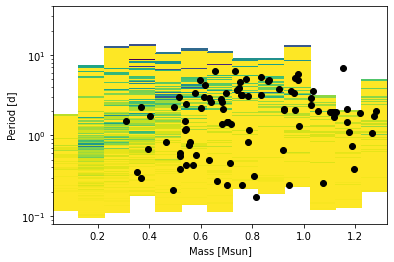

In [69]:
sm = SpinModel(2022,30,"log")
sm.normalize()
sm.add_mask()
sm.plot_hist()
plt.plot(catmatch["Mass"],catmatch["Prot1"],"ko")

# Calculating tau-squared

In [49]:
# area of the region containing the model
A_pm = (np.max(sm.mass_bins)-np.min(sm.mass_bins)) * (np.max(sm.period_bins)-np.min(sm.period_bins))
# print(A_pm,1/A_pm)

# model weight? value from section 5.2.3
fscript = 0.7

# background term in the tau squared sum
bkgd_i = (1-fscript)/A_pm

In [65]:
use = ((catmatch["Mass"]<max(sm.mass_bins)) & 
       (catmatch["Mass"]>=min(sm.mass_bins)) & 
       (catmatch["Mass"].mask==False) & 
       (catmatch["Prot1"]>0))

In [66]:
nprot = len(np.where(use)[0])
print(nprot)

91


In [67]:
bkgd_sum = bkgd_i*nprot

In [78]:
sum_rho = 0
for j in range(len(sm.period_bins)-1):
#     print(sm.period_bins[j])
    in_p_bin = (catmatch["Prot1"]>sm.period_bins[j]) & (catmatch["Prot1"]<=sm.period_bins[j+1])
    for i in range(len(sm.mass_bins)-1):
#         print(sm.mass_bins[i])
        if sm.mask[j,i]==True:
            # No model at this index; move on
#             print(sm.mask[j,i])
            continue
        else:
            in_m_bin = (catmatch["Mass"]>sm.mass_bins[i]) & (catmatch["Mass"]<=sm.mass_bins[i+1])
            observed = use & in_p_bin & in_m_bin
            n_in_bin = len(np.where(observed)[0])
            if n_in_bin>0:
                print(sm.mass_bins[i],sm.period_bins[j],n_in_bin)
                sum_rho += n_in_bin * sm.img[j,i]

0.42500000000000004 0.2041596380745416 1
0.6250000000000001 0.2386619604998335 1
0.7250000000000001 0.2386619604998335 1
0.925 0.2386619604998335 1
1.025 0.2540437591683771 1
0.6250000000000001 0.26210251839086485 1
0.32500000000000007 0.29697633767226483 1
0.7250000000000001 0.3063970012930184 1
0.32500000000000007 0.34716438390748466 1
0.42500000000000004 0.3695391798195364 1
1.125 0.3695391798195364 1
0.525 0.4187078892754483 2
0.6250000000000001 0.4456936746946136 1
0.6250000000000001 0.48946817634316125 1
0.42500000000000004 0.5545939325952718 1
0.525 0.5545939325952718 1
0.42500000000000004 0.5903375936131837 1
0.8250000000000001 0.6483185240863985 1
0.32500000000000007 0.6688844411638106 1
1.125 0.7119941423703011 1
0.525 0.7345799731734936 1
0.42500000000000004 0.806727894655005 1
0.7250000000000001 0.806727894655005 1
0.525 0.8323188632439251 1
1.225 1.0356866559884643 1
1.125 1.0685406391678844 1
0.7250000000000001 1.1374082414720597 1
0.525 1.1734890300169238 2
0.925 1.28874

In [79]:
sum_rho

0.048332754093912716

In [80]:
tau_sq = -2 * np.log(bkgd_sum + fscript*sum_rho)

In [81]:
tau_sq

1.163809454610175